## Problem 8

### Environment Setup
Make sure to change the DATA_DIR if running on your machine.

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
import scipy.stats as stats
from pymc3.math import switch
import pymc3 as pm
import theano
from theano import tensor as T
from plotnine import *
import warnings


#EDIT with your working DIR
DATA_DIR = "/home/jack/Documents/Advanced-ML-Course/Assignment_2/data"

### Data Set-Up

The following code sets up the data and some basic variables for the main part of this question.  Also plots the data.

In [21]:
data1_df = pd.read_csv(os.path.join(DATA_DIR, "change_point1.csv"))

# define some constant variables
N = data1_df.shape[0]

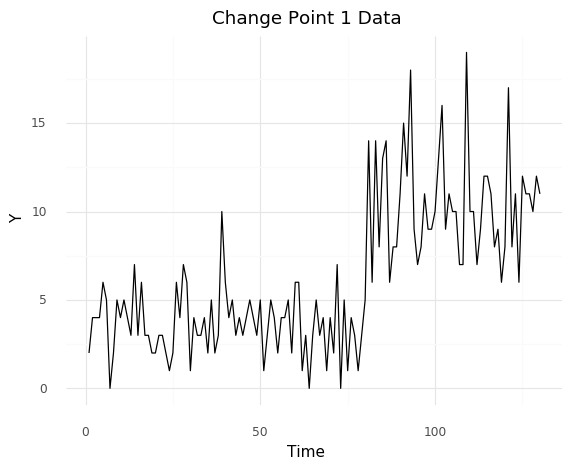

<ggplot: (-9223363246617237262)>

In [15]:
# x is just an index, the data we're interested in is y
(ggplot(data1_df) + geom_line(aes(y='y', x='x')) + 
 theme_minimal() + labs(x = "Time", y = "Y", title="Change Point 1 Data")) 

### Building the Model

In [23]:
itt = 10000 # 10,000 itterations
burnin = 300
chains = 4
t = np.arange(0,N) #"time"

with pm.Model() as model:

    #define exponential prior
    lambda_1 = pm.Exponential("lambda1", 1/data1_df.y.mean()) # set to mean of sample, which we know to be poisson
    lambda_2 = pm.Exponential('lambda2', 1/data1_df.y.mean())
    
    #define switchpoint variable
    switchpoint = pm.DiscreteUniform("switchpoint1", 0, N-1) #based on range of data
    
    # define a switch function
    lda = T.switch(switchpoint<=t, lambda_1, lambda_2)
    
    # then model an observation
    observation = pm.Poisson('obs', lda, observed=data1_df.y)
    
    #start MCMC
    trace = pm.sample(itt, random_seed=88, chains = chains, tune=2000, progressbar=True, cores=1)

Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [lambda2, lambda1]
>Metropolis: [switchpoint1]
Sampling chain 3, 0 divergences: 100%|██████████| 12000/12000 [00:08<00:00, 1435.31it/s]
The number of effective samples is smaller than 25% for some parameters.


### Model Diagnostics and Results

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea2acc2278>,
      dtype=object)

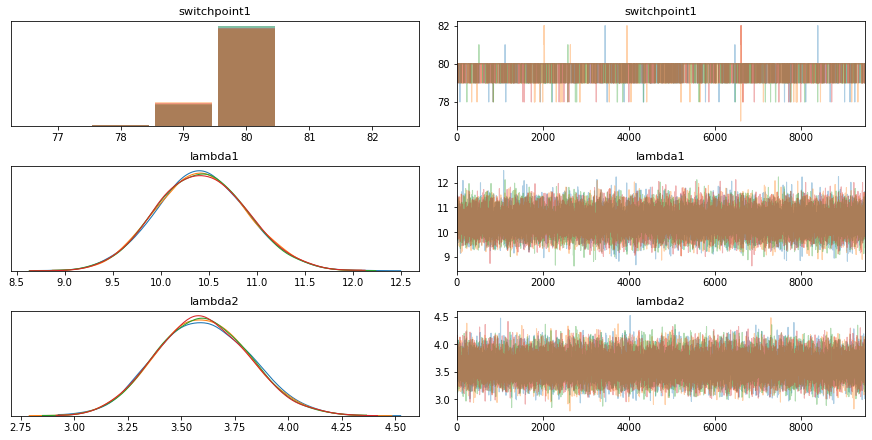

In [27]:
# plot the diagnostics of our model
warnings.filterwarnings('ignore')
pm.traceplot(trace[burnin:]) 

In [35]:
# collect data for plots
posteriors = pd.DataFrame({'lambda_1': trace['lambda1'], 
                       'lambda_2': trace['lambda2'],
                       'switchpoint1': trace['switchpoint1']})
posteriors = posteriors.unstack().reset_index()
posteriors = posteriors.rename(columns = {'level_0':'Parameter',
                                                  'level_1':'Sample',
                                                  0:'simulated_parameter'})

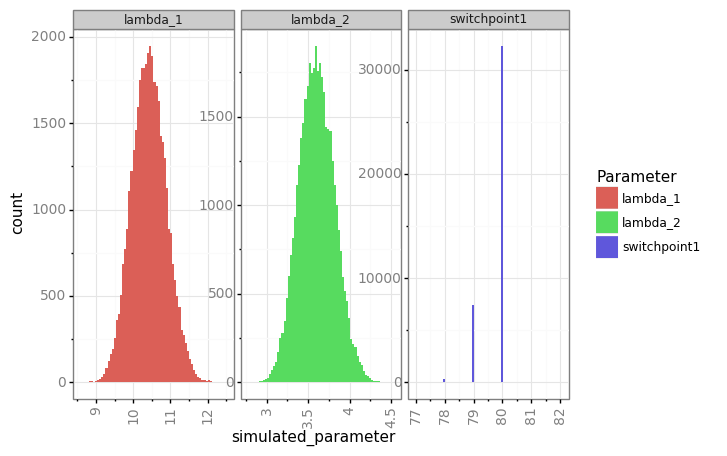

<ggplot: (8790230069203)>

In [36]:
# Plotting the simulated distribution
ggplot(aes(x = 'simulated_parameter', fill = 'Parameter'), data = posteriors)\
+ geom_histogram(bins = 70)\
+ facet_wrap(['Parameter'],scales='free')\
+ theme_bw()\
+ theme(axis_text_x = element_text(color="grey", size=10, angle=90, hjust=.5),
        axis_text_y = element_text(color="grey", size=10))